C:\Users\otsuka\AppData\Local\Temp\ipykernel_12116\1445460577.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Dark2')


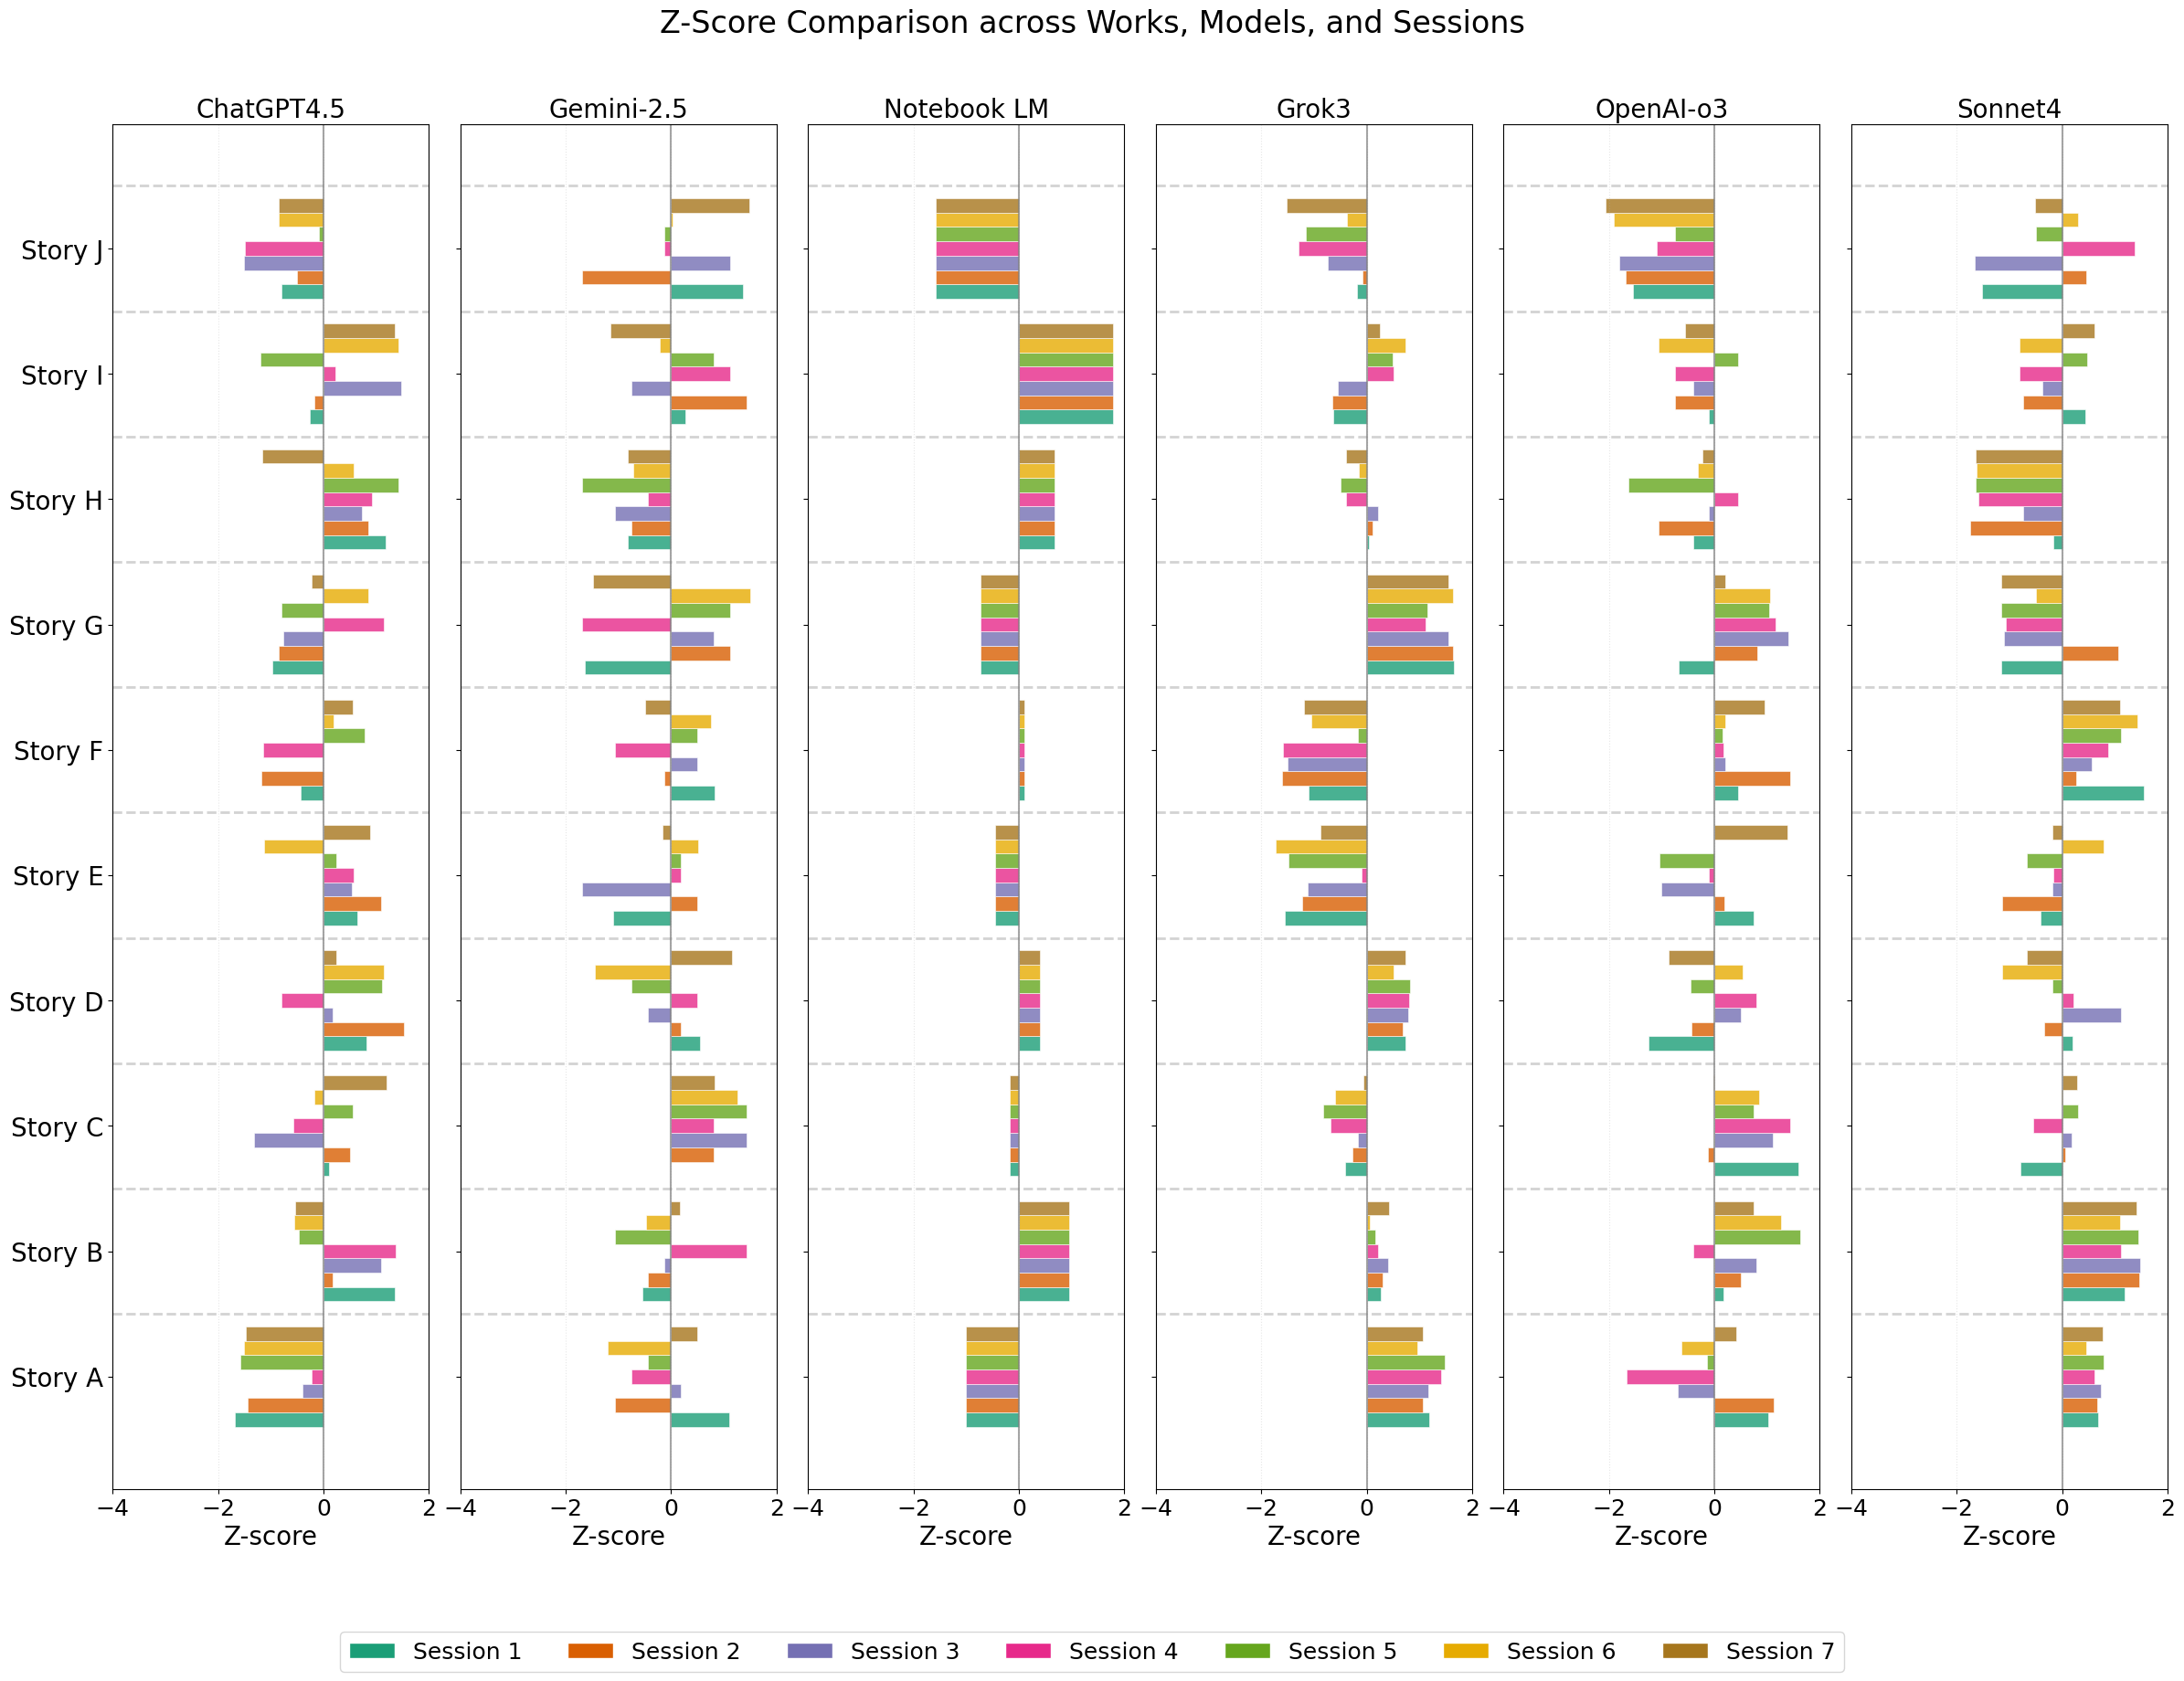

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load CSV data
df = pd.read_csv('official_row_data.csv', encoding='utf-8')

# Target models and story order
models = ['ChatGPT4.5', 'Gemini-2.5', 'Notebook LM', 'Grok3', 'OpenAI-o3', 'Sonnet4']
stories = ['Story A', 'Story B', 'Story C', 'Story D', 'Story E', 'Story F', 'Story G', 'Story H', 'Story I', 'Story J']

def calculate_session_zscores(data):
    """Compute z-scores within each session (column-wise normalization)"""
    zscores = np.zeros_like(data, dtype=float)
    for session in range(data.shape[1]):
        session_scores = data[:, session]
        mean = np.mean(session_scores)
        std = np.std(session_scores, ddof=1)
        if std > 0:
            zscores[:, session] = (session_scores - mean) / std
        else:
            zscores[:, session] = 0
    return zscores

# Compute z-scores for each model
all_results = []
for model in models:
    model_data = df[df['model'] == model]
    pivot = model_data.pivot(index='story', columns='session', values='score')
    matrix = pivot.reindex(stories).values.astype(float)
    zscores = calculate_session_zscores(matrix)
    
    for i, story in enumerate(stories):
        for j in range(7):  # Assume 7 sessions
            all_results.append({
                'story': story,
                'model': model,
                'session': j + 1,
                'z_score': round(zscores[i, j], 4)
            })

# Create final DataFrame
df = pd.DataFrame(all_results)

# Prepare unique identifiers
models = df['model'].unique()
sessions = sorted(df['session'].unique())
stories = df['story'].unique()

# Set up colormap
cmap = plt.cm.get_cmap('Dark2')
session_colors = {s: cmap(i) for i, s in enumerate(sessions)}

# Create horizontal bar plots
fig, axes = plt.subplots(1, len(models), figsize=(4 * len(models), 18), sharey=True)
if len(models) == 1:
    axes = [axes]

for i, model in enumerate(models):
    ax = axes[i]
    model_data = df[df['model'] == model]
    bar_height = 0.8 / len(sessions)
    story_spacing = 1.0

    for j, story in enumerate(stories):
        for k, session in enumerate(sessions):
            match = model_data[(model_data['story'] == story) & (model_data['session'] == session)]
            if not match.empty:
                z_score = match['z_score'].values[0]
                y_base = j * story_spacing
                y_pos = y_base + (k - len(sessions)/2) * bar_height + bar_height/2
                ax.barh(y_pos, z_score, height=bar_height,
                        color=session_colors[session], edgecolor='white', linewidth=0.5, alpha=0.8)

    for j in range(len(stories)):
        ax.axhline(j * story_spacing + 0.5, color='lightgray', linestyle='--', linewidth=2.0)

    ax.axvline(x=0, color='gray', linestyle='-', alpha=0.7)
    ax.set_yticks([j * story_spacing for j in range(len(stories))])
    ax.set_yticklabels(stories, fontsize=20)
    ax.set_title(models[i], pad=5, fontsize=20)
    ax.set_xlabel('Z-score', fontsize=20)
    ax.set_xlim(-4, 2)
    ax.grid(axis='x', linestyle=':', alpha=0.3)
    ax.tick_params(axis='x', labelsize=18)
    if i != 0:
        ax.set_ylabel('')

# Create legend
legend_elements = [Patch(facecolor=session_colors[s], edgecolor='white', label=f'Session {s}') for s in sessions]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=len(sessions), fontsize=18)

plt.suptitle('Z-Score Comparison across Works, Models, and Sessions', fontsize=24, y=1)
plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.1, wspace=0.1)
plt.show()
